In [171]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasGridSearch

import pandas as pd
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (16,8)

In [161]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [17]:
sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [18]:
def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

# Not working - changing approach

In [175]:
df_train = pd.read_csv('renttherunway-dataset/data/dataset_split/train.csv')
df_test = pd.read_csv('renttherunway-dataset/data/dataset_split/test.csv')
df_full = pd.concat([df_train,df_test])
df_time = pd.DataFrame()
df_full["full_text"] = ((f'{df_full["review_text"]} {df_full["review_summary"]} {df_full["category"]}').lower())

df_full["full_text"] = df_full["item_review_text"] = (df_full["review_text"] + 
                                                    " " + df_full["review_summary"] +
                                                    " " + df_full["category"]).astype(str).str.lower()

df_time['Month'] = df_all['review_date'].apply(lambda date: date.split(' ')[0])
df_time['Day'] = df_all['review_date'].apply(lambda date: date.split(' ')[1].replace(',',''))
df_time['Year'] = df_all['review_date'].apply(lambda date: date.split(' ')[2])

df_all

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,class_rating
0,46628,fit,345809,36b,326784,150lbs,5.0,wedding,I wore this dress for my bridal shower this pa...,athletic,Great Bridal Shower Dress,dress,"5' 6""",16,30.0,"May 3, 2016",1
1,18399,fit,45235,NaN,2766308,128lbs,5.0,everyday,I really liked this sweater. I wore it on a fl...,athletic,"Great sweater, perfect for travel!",cardigan,"5' 6""",8,34.0,"March 7, 2017",1
2,12853,fit,508677,36b,254960,145lbs,3.0,wedding,I ordered this dress and one other for a weddi...,athletic,Seeing as I didn't wear this dress....not this...,sheath,"5' 8""",16,39.0,"January 18, 2017",0
3,17290,fit,117290,34a,1687082,110lbs,5.0,wedding,This dress is so fun! Was a little tight aroun...,petite,The COLOR!!!!,gown,"5' 4""",4,33.0,"March 28, 2016",1
4,9628,fit,144767,34b,135459,NaN,4.0,party,"I get nervous about gold, especially gold lace...",pear,Opulent but Chic and Sexy,dress,"5' 5""",16,33.0,"January 11, 2016",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,7012,fit,72703,34c,1183835,140lbs,5.0,everyday,"Easy to wear, flattering for many shapes, grea...",petite,Great everyday dress for summer,dress,"5' 3""",16,34.0,"July 7, 2016",1
7483,21377,fit,101474,32c,1242444,120lbs,5.0,formal affair,This dress is truly a piece of art. The lace d...,straight & narrow,Incredible lace detailing,dress,"5' 8""",4,27.0,"November 20, 2017",1
7484,14859,small,401916,36b,665360,140lbs,3.0,party,I think this dress is darling. But it is SO sh...,athletic,Soooooo short,sheath,"5' 5""",12,39.0,"June 8, 2016",0
7485,19616,fit,490297,34b,439630,115lbs,4.0,vacation,Snagged this maxi originally for tropical vaca...,athletic,"Flattering, whimsical, multipurpose maxi",maxi,"5' 6""",4,36.0,"August 31, 2016",1


In [178]:
def month_to_num(month):
    return {
        'January' : 1,
        'February' : 2,
        'March' : 3,
        'April' : 4,
        'May' : 5,
        'June' : 6,
        'July' : 7,
        'August' : 8,
        'September' : 9, 
        'October' : 10,
        'November' : 11,
        'December' : 12
}[month]

In [179]:
df_time['Month']=df_time['Month'].apply(lambda x: month_to_num(x))

In [180]:
df_time = df_time.astype(str)
df_time['ts'] = pd.to_datetime(df_time.agg('-'.join, axis=1), format='%m-%d-%Y')

from datetime import datetime
df_time['timestamp'] = df_time['ts'].apply(lambda x: int(datetime.timestamp(x)))

In [181]:
df_time['Rating'] = df_all['rating']
df_time['user_id'] = df_all['user_id']
df_time['item_id'] = df_all['item_id']

In [182]:
df_pivot = pd.pivot_table(
      df_time,
      index='user_id',
      columns='ts',
      values='Rating',
      fill_value=0)

In [183]:
df_pivot

ts,2011-09-13,2011-10-11,2011-11-06,2011-11-14,2011-11-16,2011-11-17,2011-11-21,2011-11-29,2011-12-07,2011-12-28,...,2017-12-28,2017-12-29,2017-12-30,2017-12-31,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-07
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
332,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
551,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
657,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
836,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999425,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
999431,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
999518,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [184]:
df_avg = df_pivot.T.groupby(df_pivot.T.index.day).mean().T
df_avg

ts,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
user_id,,,,,,,,,,,,,,,,,,,,,
47,0.0,0.000000,0.0,0.064516,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.080645,0.000000,0.0,0.078125,0.000000,0.000000,0.000000,0.066667,0.0,0.0
332,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.079365,0.000000,0.000000,0.000000,0.0,0.0
551,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.087719,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
657,0.0,0.000000,0.0,0.000000,0.000000,0.063492,0.076923,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
836,0.0,0.000000,0.0,0.080645,0.000000,0.000000,0.000000,0.0,0.081967,0.000000,...,0.000000,0.080645,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999425,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
999431,0.0,0.000000,0.0,0.000000,0.000000,0.047619,0.000000,0.0,0.081967,0.000000,...,0.064516,0.072581,0.0,0.000000,0.000000,0.000000,0.079365,0.000000,0.0,0.0
999518,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.087719,...,0.000000,0.000000,0.0,0.000000,0.063492,0.000000,0.000000,0.000000,0.0,0.0


In [185]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=3, learning_method='batch')
lda = lda.fit(df_avg)

In [186]:
df_comp = pd.DataFrame(lda.components_.T, index=df_avg.columns)
df_comp

,0,1,2
ts,,,
1,49.219636,19.952133,11.407623
2,8.047427,36.068826,41.024445
3,17.142060,49.808349,9.190317
4,10.678023,46.511810,17.335864
5,1.255562,1.258340,81.070489
6,66.423499,4.504213,12.760648
7,52.954758,3.860993,17.632805
8,7.596376,44.120450,39.997710
9,16.638880,19.788654,42.909174


In [187]:
# assign each vector the cluster withwhich it is most associated
df_avg['cluster'] = np.argmax(lda.transform(df_avg), axis=1)
df_avg

ts,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
47,0.0,0.000000,0.0,0.064516,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.078125,0.000000,0.000000,0.000000,0.066667,0.0,0.0,1
332,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.079365,0.000000,0.000000,0.000000,0.0,0.0,0
551,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.087719,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
657,0.0,0.000000,0.0,0.000000,0.000000,0.063492,0.076923,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0
836,0.0,0.000000,0.0,0.080645,0.000000,0.000000,0.000000,0.0,0.081967,0.000000,...,0.080645,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999425,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
999431,0.0,0.000000,0.0,0.000000,0.000000,0.047619,0.000000,0.0,0.081967,0.000000,...,0.072581,0.0,0.000000,0.000000,0.000000,0.079365,0.000000,0.0,0.0,0
999518,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.087719,...,0.000000,0.0,0.000000,0.063492,0.000000,0.000000,0.000000,0.0,0.0,0


In [124]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

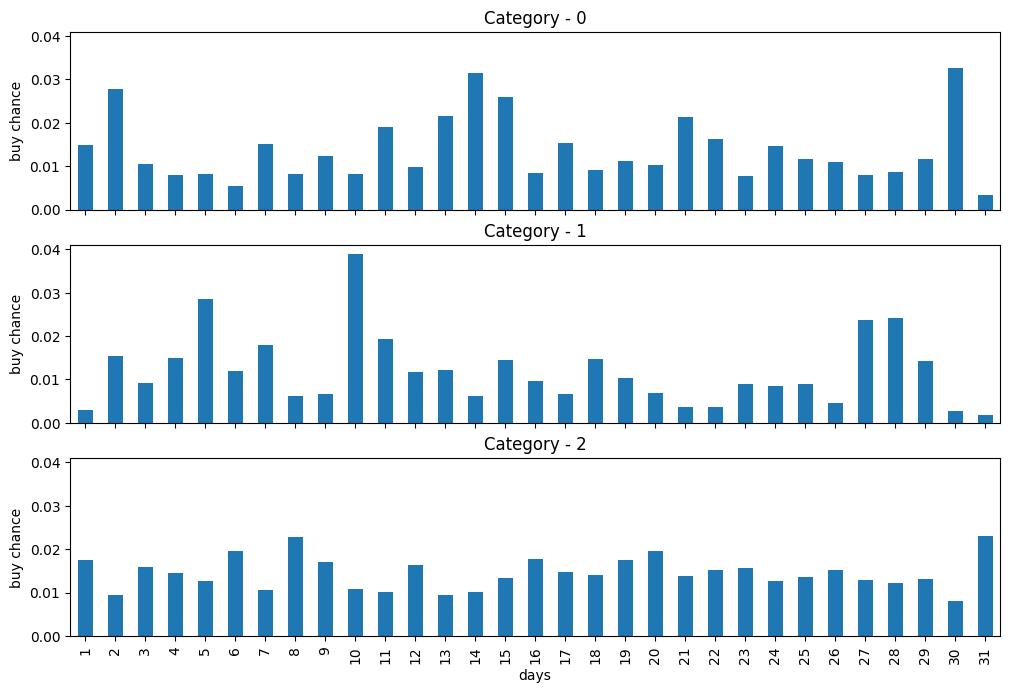

In [134]:
#plt.figure(figsize=(50,20))
#chart the different clusters

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

df_avg.iloc[:,:-1].loc[df_avg.cluster == 0].mean().plot.bar(ax=axs[0])
axs[0].set_title('Category - 0')

df_avg.iloc[:,:-1].loc[df_avg.cluster == 1].mean().plot.bar(ax=axs[1])
axs[1].set_title('Category - 1')

df_avg.iloc[:,:-1].loc[df_avg.cluster == 2].mean().plot.bar(ax=axs[2])
axs[2].set_title('Category - 2')

# df_avg.iloc[:,:-1].loc[df_avg.cluster == 2].mean().plot.bar(ax=axs[3])
# axs[3].set_title('Category - 3')

# df_avg.iloc[:,:-1].loc[df_avg.cluster == 2].mean().plot.bar(ax=axs[4])
# axs[4].set_title('Category - 4')

for ax in axs.flat:
    ax.set(xlabel='days', ylabel='buy chance')

In [196]:
df_avg_month = df_pivot.T.groupby(df_pivot.T.index.month).mean().T
df_avg_month

ts,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
47,0.0,0.000000,0.000000,0.027027,0.033557,0.034247,0.000000,0.026144,0.000000,0.000000,0.000000,0.023392
332,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030675,0.029240,0.000000,0.000000
551,0.0,0.035971,0.000000,0.000000,0.000000,0.034247,0.026846,0.000000,0.000000,0.029240,0.000000,0.000000
657,0.0,0.000000,0.000000,0.000000,0.000000,0.123288,0.000000,0.000000,0.000000,0.023392,0.000000,0.000000
836,0.0,0.035971,0.000000,0.000000,0.000000,0.000000,0.000000,0.032680,0.052147,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
999425,0.0,0.000000,0.000000,0.027027,0.000000,0.000000,0.026846,0.000000,0.000000,0.000000,0.000000,0.000000
999431,0.0,0.000000,0.000000,0.000000,0.000000,0.068493,0.090604,0.019608,0.000000,0.000000,0.017751,0.000000
999518,0.0,0.028777,0.000000,0.000000,0.026846,0.000000,0.020134,0.032680,0.024540,0.000000,0.000000,0.000000


In [197]:
lda_month = LDA(n_components=3, learning_method='batch')
lda_month = lda_month.fit(df_avg_month)

In [198]:
df_comp_month = pd.DataFrame(lda_month.components_.T, index=df_avg_month.columns)
df_comp_month

,0,1,2
ts,,,
1,11.018102,26.405315,23.025817
2,8.314728,42.957364,13.341897
3,4.115082,65.703084,5.164172
4,13.678222,54.683837,13.898904
5,28.091155,19.590073,43.861276
6,19.666680,17.791455,64.323370
7,6.995143,6.726313,62.024755
8,11.299177,35.829102,32.168665
9,46.501333,19.188204,12.862866


In [200]:
df_avg_month['cluster'] = np.argmax(lda_month.transform(df_avg_month), axis=1)
df_avg_month

ts,1,2,3,4,5,6,7,8,9,10,11,12,cluster
user_id,,,,,,,,,,,,,
47,0.0,0.000000,0.000000,0.027027,0.033557,0.034247,0.000000,0.026144,0.000000,0.000000,0.000000,0.023392,2
332,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030675,0.029240,0.000000,0.000000,0
551,0.0,0.035971,0.000000,0.000000,0.000000,0.034247,0.026846,0.000000,0.000000,0.029240,0.000000,0.000000,2
657,0.0,0.000000,0.000000,0.000000,0.000000,0.123288,0.000000,0.000000,0.000000,0.023392,0.000000,0.000000,2
836,0.0,0.035971,0.000000,0.000000,0.000000,0.000000,0.000000,0.032680,0.052147,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999425,0.0,0.000000,0.000000,0.027027,0.000000,0.000000,0.026846,0.000000,0.000000,0.000000,0.000000,0.000000,2
999431,0.0,0.000000,0.000000,0.000000,0.000000,0.068493,0.090604,0.019608,0.000000,0.000000,0.017751,0.000000,2
999518,0.0,0.028777,0.000000,0.000000,0.026846,0.000000,0.020134,0.032680,0.024540,0.000000,0.000000,0.000000,2


In [190]:
df_train["full_text"] = (df_train["review_text"] + 
                         " " + df_train["review_summary"] +
                         " " + df_train["category"]).astype(str).str.lower()

In [191]:
text_agg_item= df_train.groupby(
     ['item_id']
 ).agg(
     full_text = ('full_text','sum'),
 ).reset_index()


In [192]:
text_agg_item = pd.DataFrame(df_train.groupby("item_id")["full_text"].sum())
text_agg_item

,full_text
item_id,
123373,"i love black dresses. long, short, casual, dre..."
123793,this dress has been reviewed and worn a millio...
124204,"this was my back up dress for a wedding and, f..."
124553,i wore this dress to a work even with my husba...
125424,this was a wonderful dress. i usually don't we...
...,...
2963344,"great fit, comfortable, different color that g..."
2963850,loved this skirt! print is unique and length w...
2964470,i loved this sweater from tory burch. i didn't...


In [193]:
tfIdfVectorizer=TfidfVectorizer(stop_words='english')
tfIdf = tfIdfVectorizer.fit_transform(df_full_text_cat['full_text'])
df_most_popular = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
print (df_most_popular.head(50))

                 TF-IDF
dress          0.463999
slit           0.246342
draping        0.207568
gowni          0.206438
long           0.195097
heels          0.140770
inch           0.120996
short          0.119024
black          0.108318
gownthe        0.100872
wore           0.096138
perfect        0.094520
little         0.090609
event          0.084291
bit            0.083658
wear           0.082023
sexy           0.081601
felt           0.080983
places         0.079587
length         0.078097
fit            0.077476
gown           0.075297
2r             0.072149
tie            0.070428
like           0.069243
floor          0.068640
great          0.067892
sleeves        0.067790
disappointing  0.067564
ruching        0.066266
loved          0.065577
2l             0.064907
just           0.064602
bm             0.063080
leg            0.062374
comfortable    0.062005
addams         0.061814
ordered        0.061679
gownthis       0.061605
spanx          0.061015
morticia       0

In [201]:
tfIdfVectorizer_stopwords = TfidfVectorizer(stop_words='english')
tfIdf = tfIdfVectorizer_stopwords.fit_transform(text_agg_item["full_text"])
tfidf_similarity = cosine_similarity(tfIdf, tfIdf)
tfidf_similarity_df = pd.DataFrame(tfidf_similarity,
                                   columns=text_agg_item.index,
                                   index=text_agg_item.index)

tfidf_similarity_df.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2959486,2960025,2960940,2960969,2962646,2963344,2963850,2964470,2965009,2966087
item_id,,,,,,,,,,,,,,,,,,,,,
123373,1.000000,0.636957,0.451958,0.520706,0.484200,0.569328,0.572645,0.514432,0.409091,0.506000,...,0.140021,0.080588,0.034626,0.169292,0.079734,0.077768,0.140932,0.063310,0.052503,0.182796
123793,0.636957,1.000000,0.614557,0.560300,0.529526,0.647962,0.624262,0.708029,0.468717,0.508815,...,0.138300,0.112080,0.055459,0.151972,0.060878,0.067053,0.141019,0.059687,0.067607,0.175472
124204,0.451958,0.614557,1.000000,0.588896,0.545858,0.453714,0.402660,0.743998,0.318101,0.555078,...,0.146273,0.075467,0.054926,0.141399,0.084179,0.087755,0.135613,0.083059,0.073292,0.125553
124553,0.520706,0.560300,0.588896,1.000000,0.706743,0.598038,0.481823,0.665416,0.377788,0.616875,...,0.167106,0.099131,0.062982,0.217719,0.136849,0.138257,0.194768,0.093027,0.062336,0.149736
125424,0.484200,0.529526,0.545858,0.706743,1.000000,0.485630,0.454304,0.632764,0.364412,0.568717,...,0.171479,0.090394,0.069032,0.236074,0.112394,0.105609,0.179542,0.091871,0.069654,0.149242


In [244]:
def make_recommendation(target_user_id, tfidf_sim_df, ic_month, ic_day, top_n = 20, time_method= None):

    if time_method == 'month':
        cluster = ic_month[ic_month.index==target_user_id].values[0]
        item_pool = df_train[df_train['cluster_month']==cluster]
    if time_method == 'day':
        cluster = ic_day[ic_day.index==target_user_id].values[0]
        item_pool = df_train[df_train['cluster_day']==cluster]
    else:
        item_pool = df_train
        
    top_item_id = int(df_train[df_train.user_id == target_user_id].head(1).item_id)
    df_similarity = tfidf_sim_df[[top_item_id]].sort_values([top_item_id], ascending=False)
    df_similarity = df_similarity.iloc[1:]
    df_similarity = df_similarity[top_item_id] 
    return df_similarity.head(top_n)

In [246]:
from tqdm import tqdm

df_train['cluster_month'] = df_train['user_id'].apply(lambda inx : df_avg_month[df_avg_month.index==inx].cluster.values[0])
df_train['cluster_day'] = df_train['user_id'].apply(lambda inx : df_avg[df_avg.index==inx].cluster.values[0])

In [248]:
test_results = {}

ic_month = df_train.groupby(['user_id'])['cluster_month'].agg(lambda x:x.value_counts().index[0])
ic_day = df_train.groupby(['user_id'])['cluster_day'].agg(lambda x:x.value_counts().index[0])

for user_id in tqdm(df_test['user_id'].values):
    items_similarities = make_recommendation(target_user_id = user_id, tfidf_sim_df =tfidf_similarity_df,ic_month = ic_month, ic_day = ic_day, top_n = 100, time_method = 'day')
    item_sim = {}
    for item_id, sim in items_similarities.items():
        item_sim[str(item_id)] = float(sim)
    test_results[str(user_id)] = item_sim

with open('tfidf_results_top_100_time_day.json', 'w') as outfile:
    json.dump(test_results, outfile)

100%|██████████| 7487/7487 [00:50<00:00, 147.82it/s]
